#Ini adalah pipeline untuk Enrichment Analysis dan Membandingkan gene tertentu dari sel tertentu

In [4]:
#upload library
library(Seurat)
library(ggplot2)
library(dplyr)
library(stringr)
library(tidyr)
library(org.Hs.eg.db)
library(msigdbr)
library(clusterProfiler)
library(writexl)

Loading required package: SeuratObject

Loading required package: sp

'SeuratObject' was built under R 4.4.1 but the current version is
4.4.2; it is recomended that you reinstall 'SeuratObject' as the ABI
for R may have changed


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following object is masked from 'package:SeuratObject':

    intersect


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package

In [5]:
#upload file
data <- readRDS("pbmc_ra_QC.rds")

In [6]:
#Gene Ontology (GO) Enrichment

pathway_results <- list()
cell_types <- unique(data$fine_annot)
for (cell_type in cell_types) {
  cat("Processing cell type:", cell_type, "\n")
  # Step 1: Filter data untuk tipe sel tertentu
  cell <- subset(data, subset = fine_annot == factor(cell_type, levels = levels(data@meta.data$fine_annot)))
  # Step 2: Analisis DEG berdasarkan penyakit
  Idents(cell) <- "disease"
  markers_cell <- FindMarkers(cell, ident.1 = "rheumatoid arthritis", ident.2 = "normal")
  # Step 3: Filter significant markers
  filtered_markers <- markers_cell[markers_cell$p_val_adj < 0.05 & abs(markers_cell$avg_log2FC) > 0.15, ]
  # Step 4: Enrichment Analysis (dengan GO)
  gene_id <- rownames(filtered_markers)
  gene_entrez <- bitr(gene_id, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)
  gene_entrez <- na.omit(gene_entrez)
  go_results <- enrichGO(
    gene = gene_entrez$ENTREZID,
    OrgDb = org.Hs.eg.db,
    keyType = "ENTREZID",
    ont = "BP",
    pAdjustMethod = "BH",
    pvalueCutoff = 0.05,
    qvalueCutoff = 0.05
  )
  # Simpan hasil pathway untuk tiap tipe sel
  pathway_results[[cell_type]] <- go_results
}

Processing cell type: Myeloid DCs 


For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

'select()' returned 1:1 mapping between keys and columns



Processing cell type: CD8 TEMRA 


'select()' returned 1:1 mapping between keys and columns



Processing cell type: CD4 T Naive 


'select()' returned 1:1 mapping between keys and columns



Processing cell type: Naive Bcells 


--> No gene can be mapped....

--> Expected input gene ID: 3276,113510,51010,84083,127898561,100133315

--> return NULL...



Processing cell type: Classical Monocytes 


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_id, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
"5.26% of input gene IDs are fail to map..."


Processing cell type: NKCD56low 


--> No gene can be mapped....

--> Expected input gene ID: 3276,113510,51010,84083,127898561,100133315

--> return NULL...



Processing cell type: CD8 T Naive 


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_id, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
"33.33% of input gene IDs are fail to map..."


Processing cell type: CD4 T central memory 


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_id, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
"1.91% of input gene IDs are fail to map..."


Processing cell type: Non-classical Monocytes 


'select()' returned 1:1 mapping between keys and columns



Processing cell type: CD4 T effector memory 


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene_id, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
"3.31% of input gene IDs are fail to map..."


Processing cell type: yd T cells 


--> No gene can be mapped....

--> Expected input gene ID: 3276,113510,51010,84083,127898561,100133315

--> return NULL...



Processing cell type: CD4 T IFIT 


--> No gene can be mapped....

--> Expected input gene ID: 3276,113510,51010,84083,127898561,100133315

--> return NULL...



Processing cell type: NKCD56bright 


'select()' returned 1:1 mapping between keys and columns



Processing cell type: Memory Bcells 


'select()' returned 1:1 mapping between keys and columns



Processing cell type: CD8 T early Tem 


'select()' returned 1:1 mapping between keys and columns



Processing cell type: Plasmablasts 


--> No gene can be mapped....

--> Expected input gene ID: 3276,113510,51010,84083,127898561,100133315

--> return NULL...



Processing cell type: IL1b-Monocytes 


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene_id, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
"3.47% of input gene IDs are fail to map..."


Processing cell type: IFITM3 Monocytes 


'select()' returned 1:1 mapping between keys and columns



In [7]:
# Install and load writexl if not installed
# install.packages("writexl")
library(writexl)

# Convert pathway_results to a data frame (or list of data frames) for saving
# Each cell type will have its own sheet in the Excel file
pathway_results_df <- lapply(pathway_results, function(go_result) {
  if (!is.null(go_result)) {
    return(as.data.frame(go_result))  # convert GO results to data frame
  } else {
    return(NULL)
  }
})

# Save the data to an Excel file
#write_xlsx(pathway_results_df, "GO_enrichment_results.xlsx")


In [7]:
pathway_results_df$`Classical Monocytes`

,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0002468,GO:0002468,dendritic cell antigen processing and presentation,4/35,16/18986,0.25000000,135.614286,23.149453,1.733296e-08,2.400615e-05,1.614702e-05,7057/6556/219972/10875,4
GO:0019882,GO:0019882,antigen processing and presentation,6/35,118/18986,0.05084746,27.582567,12.447962,7.103968e-08,4.919498e-05,3.308953e-05,1520/7057/6556/219972/10875/3133,6
GO:0002604,GO:0002604,regulation of dendritic cell antigen processing and presentation,3/35,11/18986,0.27272727,147.942857,20.949670,9.373857e-07,4.327597e-04,2.910829e-04,7057/6556/10875,3
GO:0140467,GO:0140467,integrated stress response signaling,4/35,48/18986,0.08333333,45.204762,13.177890,1.777199e-06,6.153552e-04,4.139004e-04,9935/1051/3309/3726,4
GO:0002577,GO:0002577,regulation of antigen processing and presentation,3/35,20/18986,0.15000000,81.368571,15.453848,6.403198e-06,1.773686e-03,1.193017e-03,7057/6556/10875,3
GO:0048002,GO:0048002,antigen processing and presentation of peptide antigen,4/35,72/18986,0.05555556,30.136508,10.644746,9.106396e-06,2.102060e-03,1.413888e-03,1520/6556/219972/3133,4
GO:0002478,GO:0002478,antigen processing and presentation of exogenous peptide antigen,3/35,41/18986,0.07317073,39.691986,10.658324,5.830755e-05,1.153657e-02,7.759727e-03,1520/219972/3133,3
GO:0019884,GO:0019884,antigen processing and presentation of exogenous antigen,3/35,50/18986,0.06000000,32.547429,9.599047,1.059956e-04,1.835049e-02,1.234291e-02,1520/219972/3133,3
GO:0097067,GO:0097067,cellular response to thyroid hormone stimulus,2/35,12/18986,0.16666667,90.409524,13.314296,2.153840e-04,2.974800e-02,2.000911e-02,1520/1508,2


In [18]:
#Pilih beberapa pathway yang ingin dianalisis dan divisualisasikan
pathway <- c(
             "dendritic cell antigen processing and presentation",
             "osteoclast differentiation",
             "regulation of inflammatory response",
             "antigen processing and presentation of peptide or polysaccharide antigen via MHC class II",
             "regulation of antigen processing and presentation",
             "regulation of T cell activation"
             )

In [19]:
# Ambil hasil pathway untuk "Classical Monocytes"
selected_pathway <- pathway_results[["Classical Monocytes"]]
filtered_pathway <- selected_pathway@result %>%
  filter(Description %in% pathway)

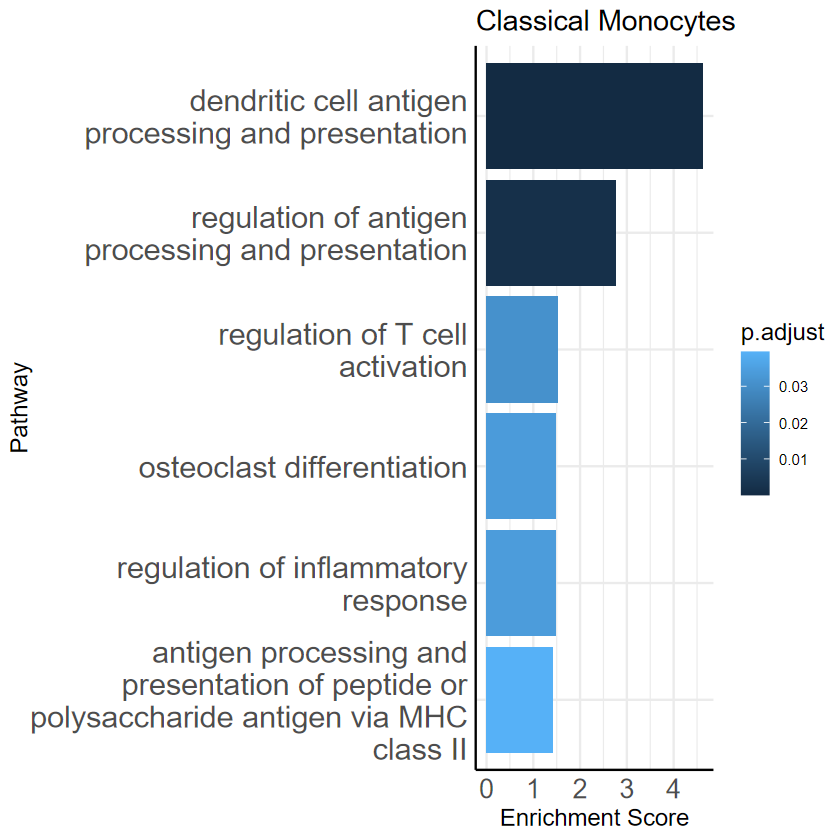

In [20]:
# Memperbaiki label pathway agar terpotong ke bawah jika terlalu panjang
filtered_pathway$Description <- str_wrap(filtered_pathway$Description, width = 30)

# Plot dengan teks lebih rapi
ggplot(filtered_pathway, aes(x = reorder(Description, -p.adjust), y = -log10(p.adjust), fill = p.adjust)) +
  geom_bar(stat = "identity") +
  coord_flip() +  # Membalik sumbu X dan Y
  labs(title = "Classical Monocytes", x = "Pathway", y = "Enrichment Score") +
  theme_minimal() +
  theme(axis.text.x = element_text(size = 16),  # Ukuran teks agar lebih terbaca
        axis.text.y = element_text(size = 18),
        axis.title.x = element_text(size = 14),  # Sesuaikan ukuran teks sumbu Y
        axis.title.y = element_text(size = 14),
        axis.line = element_line(color = "black"),
        title = element_text(size=14))  # Sesuaikan ukuran teks sumbu Y

ggsave("Classical Monocytes_pathways.png", width = 10, height = 8)

Processing pathway: antigen processing and presentation of peptide antigen via MHC class II 


'select()' returned 1:many mapping between keys and columns



Processing pathway: canonical NF-kappaB signal transduction 


'select()' returned 1:1 mapping between keys and columns



Processing pathway: chemokine production 


'select()' returned 1:many mapping between keys and columns



Processing pathway: dendritic cell antigen processing and presentation 


'select()' returned 1:many mapping between keys and columns



Processing pathway: positive regulation of canonical NF-kappaB signal transduction 


'select()' returned 1:1 mapping between keys and columns



Processing pathway: positive regulation of chemokine production 


'select()' returned 1:many mapping between keys and columns



Processing pathway: positive regulation of NF-kappaB transcription factor activity 


'select()' returned 1:1 mapping between keys and columns



Processing pathway: positive regulation of protein serine/threonine kinase activity 


'select()' returned 1:1 mapping between keys and columns



Processing pathway: positive regulation of T cell migration 


'select()' returned 1:many mapping between keys and columns



Processing pathway: positive regulation of tumor necrosis factor production 


'select()' returned 1:many mapping between keys and columns



Processing pathway: positive regulation of tumor necrosis factor superfamily cytokine production 


'select()' returned 1:many mapping between keys and columns



Processing pathway: regulation of chemokine production 


'select()' returned 1:many mapping between keys and columns



Processing pathway: regulation of kinase activity 


'select()' returned 1:1 mapping between keys and columns



Processing pathway: regulation of T cell activation 


'select()' returned 1:many mapping between keys and columns



Processing pathway: regulation of tumor necrosis factor production 


'select()' returned 1:many mapping between keys and columns



Processing pathway: regulation of tumor necrosis factor superfamily cytokine production 


'select()' returned 1:many mapping between keys and columns



Processing pathway: tumor necrosis factor production 


'select()' returned 1:many mapping between keys and columns



Processing pathway: tumor necrosis factor superfamily cytokine production 


'select()' returned 1:many mapping between keys and columns



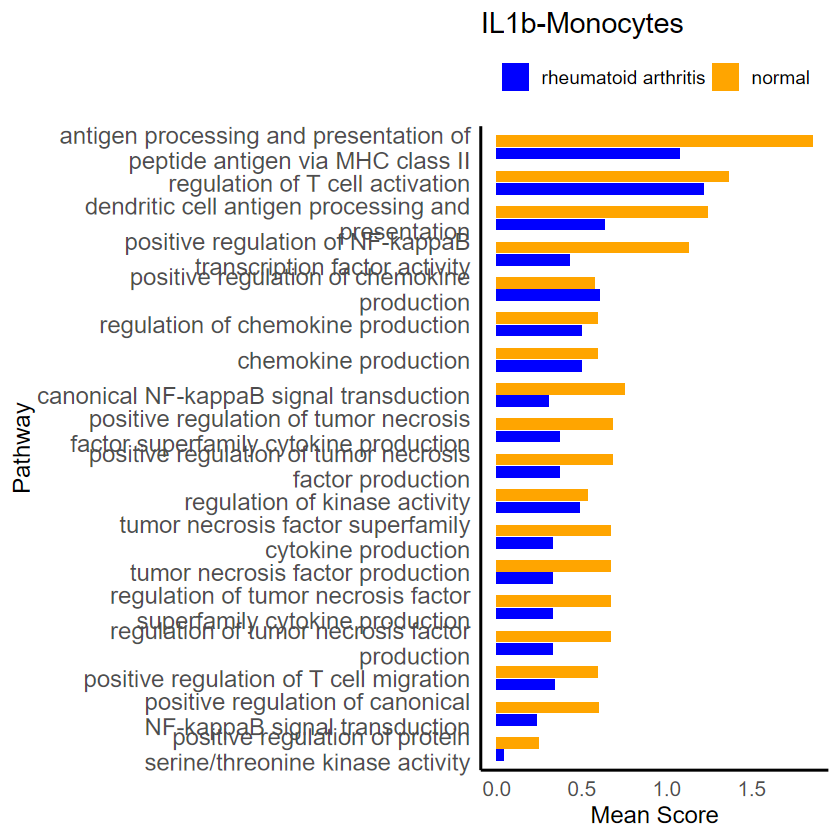

In [156]:
pathway_scores <- list()
for (p in pathway) {
  cat("Processing pathway:", p, "\n")
  
  # Ambil hasil pathway analysis
  selected_pathway <- pathway_results[["IL1b-Monocytes"]]
  
  # Filter pathway yang sesuai dengan nama p
  filtered_pathway <- selected_pathway@result %>% filter(Description == p)
  
  if (nrow(filtered_pathway) == 0) {
      cat("Pathway tidak ditemukan:", p, "\n")
      next
  }
  
  # Ambil daftar gen dalam pathway (ENTREZ ID)
  genes_in_pathway <- unique(unlist(strsplit(filtered_pathway$geneID, "/")))

  # Konversi ENTREZ ID ke ENSEMBL ID
  gene_conversion <- bitr(genes_in_pathway, fromType = "ENTREZID", toType = "ENSEMBL", OrgDb = org.Hs.eg.db)
  
  if (nrow(gene_conversion) == 0) {
      cat("Tidak ada gen yang berhasil dikonversi untuk pathway:", p, "\n")
      next
  }
  
  ensembl_genes <- gene_conversion$ENSEMBL

  # Pastikan hanya gen yang ada dalam data Seurat
  genes_in_pathway <- intersect(ensembl_genes, rownames(cell))
  
  if (length(genes_in_pathway) == 0) {
      cat("Tidak ada gen yang cocok dalam Seurat untuk pathway:", p, "\n")
      next
  }

  # Tambahkan skor pathway ke objek Seurat
  pathway_score_col <- paste0("Pathway_Score_", gsub(" ", "_", p))
  cell <- AddModuleScore(cell, features = list(genes_in_pathway), name = pathway_score_col)

  # Pastikan hasil AddModuleScore tersedia
  pathway_score_col_final <- paste0(pathway_score_col, "1")
  if (!(pathway_score_col_final %in% colnames(cell@meta.data))) {
      cat("Gagal menghitung skor untuk pathway:", p, "\n")
      next
  }

  # Simpan skor pathway
  pathway_scores[[p]] <- cell@meta.data[, c("disease", pathway_score_col_final)]
}

# Gabungkan hasil menjadi satu dataframe
pathway_df <- bind_rows(
  lapply(names(pathway_scores), function(p) {
    df <- pathway_scores[[p]]
    colnames(df)[2] <- "Pathway_Score"
    df$Pathway <- p
    return(df)
  })
)

# Hitung rata-rata skor per pathway dan penyakit
pathway_summary <- pathway_df %>%
  group_by(Pathway, disease) %>%
  summarise(Mean_Score = mean(Pathway_Score), .groups = "drop")

# Format teks pathway agar rapi di plot
pathway_summary$Pathway <- str_wrap(pathway_summary$Pathway, width = 40)

# Plot hasilnya
ggplot(pathway_summary, aes(x = reorder(Pathway, Mean_Score), y = Mean_Score, fill = disease)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +  
  scale_fill_manual(values = c("normal" = "orange", "rheumatoid arthritis" = "blue")) +  
  labs(title = "IL1b-Monocytes",
       x = "Pathway",
       y = "Mean Score") +  
  theme_minimal(base_size = 14) +  
  theme(axis.line = element_line(color = "black"),  # Menampilkan garis sumbu X dan Y
        axis.text.x = element_text(size = 12),  
        axis.text.y = element_text(size = 14),  
        legend.title = element_blank(),  
        legend.position = "top",
        panel.grid = element_blank()) +  
  coord_flip()

# Simpan gambar jika perlu
ggsave("IL1b-Monocytes_addModuleScore.png", width = 12, height = 10)
